# Problem 9

In [1]:
from sklearn import cluster, datasets, mixture
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
X, y = datasets.make_moons(n_samples=300, noise=0.06)

# 9.A: Gaussian Parameters Estimation

Separating Points of Each class:

In [3]:
class0_data = X[y == 0]
class1_data = X[y == 1]

Maximum Likelihood Estimation of mean and covariance:

In [4]:
class0_miu = class0_data.mean(axis=0)
class0_Sigma = np.cov(class0_data.T)

class1_miu = class1_data.mean(axis=0)
class1_Sigma = np.cov(class1_data.T)

means = [class0_miu, class1_miu]
covs = [class0_Sigma, class1_Sigma]

Multivariate Gaussian Function:

In [5]:
def gaussian_prob(miu, Sigma, X):
    result = []
    for x in X:
        d = miu.shape[0]
        SigmaDet = np.linalg.det(Sigma)
        SigmaInv = np.linalg.inv(Sigma)
        partOne = 1/((SigmaDet**0.5) * (2*np.pi)**(d/2))
        partTwo = np.exp(-0.5*(x.T-miu).T.dot(SigmaInv).dot(x-miu))
        result.append(partOne * partTwo)
    return result

Utilities used for plotting the data points and contours:

In [6]:
from matplotlib.patches import Ellipse

def plot_data(ax, X, y_pred, zorder):
    ax.scatter(X['red'], X['blue'], c=y_pred, zorder=2);
    ax.set_title('Distribution of mean R,B of images')
    ax.set_xlabel('red')
    ax.set_ylabel('blue') ##Chelsea

def plot_contour(ax, g_params):
    for xy, covariance in g_params:
        
        U, s, Vt = np.linalg.svd(covariance + 1e-6*np.identity(2))        
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))    
        width, height = 2 * np.sqrt(s) 
        
        for nsig in [1, 1.5, 2]:
            ax.add_patch(Ellipse(xy, nsig * width, nsig * height,
                                 angle, alpha= 0.1))
        
def plot_results(X, y_pred, g_params):
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.axis('equal')

    plot_data(ax, X, y_pred, zorder=2)
    plot_contour(ax, g_params)

Plotting part A result:

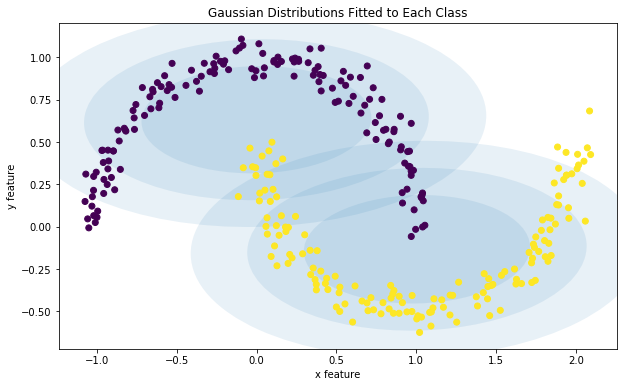

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X[:,0], X[:,1], c=y, zorder=2)
g_params = zip(means, covs)
plot_contour(ax, g_params)
ax.set_xlabel('x feature')
ax.set_ylabel('y feature')
ax.set_title('Gaussian Distributions Fitted to Each Class');

# 9.b: GMM Clustering

In [8]:
## this constant is added to covariance matrix to avoid zero determinent
cons = 1e-6*np.identity(2)

#### We define a GMM class:

In [9]:
class GMM:
    def __init__(self, num_components, iterations):
        self.k = num_components
        self.stop = iterations
    
    def init_params(self, X):
        num_features = X.shape[1]
        dim1_range = min(X[:,0]), max(X[:,0])
        
        self.alphas = np.ones(self.k) / self.k
        self.mius = np.random.randint(-5, 5, size=(self.k, num_features))
        self.covs = [np.identity(num_features) for i in range(self.k)]
        
    ## Here we find the expectation
    def E_step(self, X):
        
        num_samples = len(X)
        self.ric = np.zeros((num_samples, self.k))
        
        for alpha, mu, cov, i in zip(self.alphas, self.mius, self.covs, range(len(self.ric[0]))):
            self.ric[:, i] = alpha * multivariate_normal(mean=mu, cov=cov + cons).pdf(X)

        for i in range(len(self.ric)):
            self.ric[i, :] = self.ric[i, :] / np.sum(self.ric[i, :])
            
    ## Here we maximize the found expectation 
    def M_step(self, X):
        
        self.mc = np.sum(self.ric, axis=0)
        self.alphas = self.mc/np.sum(self.mc)
        self.mius = np.dot(self.ric.T, X) / self.mc.reshape(self.k, 1)

        self.covs = []

        for i in range(len(self.alphas)):
            covc = 1/self.mc[i] * (np.dot((self.ric[:, i].reshape(len(X), 1)*(X-self.mius[i])).T, X - self.mius[i]))
            self.covs.append(covc)
        self.covs = np.asarray(self.covs)
            
    def fit(self, X):
        
        self.init_params(X)
        for iters in range(self.stop):    
            self.E_step(X)
            self.M_step(X)
            
    ## This funtion find the log likilihood which is used in AIC and BIC
    def predict(self, X):
        preds = []
        for i in range(self.k):
            cons = 1e-6*np.identity(2)
            p = self.alphas[i] * multivariate_normal(self.mius[i], self.covs[i] + cons).pdf(X)
            preds.append(p)
        preds = np.array(preds)
        return(preds.sum(0))
    
    ## Total number of free parameters which is used in AIC and BIC
    def  _n_parameters(self):
        num_features = X.shape[1]
        cov_params = self.k * num_features * (num_features + 1) / 2
        mean_params = num_features * self.k
        return int(cov_params + mean_params + self.k - 1)
        
    def bic(self, X):
        probs = self.predict(X)
        likelihood_sum = np.sum(probs)
        
        return (-2 * likelihood_sum +
        self._n_parameters() * np.log(X.shape[0]))
    
    def aic(self, X):
        probs = self.predict(X)
        likelihood_sum = np.sum(probs)
        
        return -2 * likelihood_sum + 2 * self._n_parameters()
        

## Plotting contours for 5 numbers:

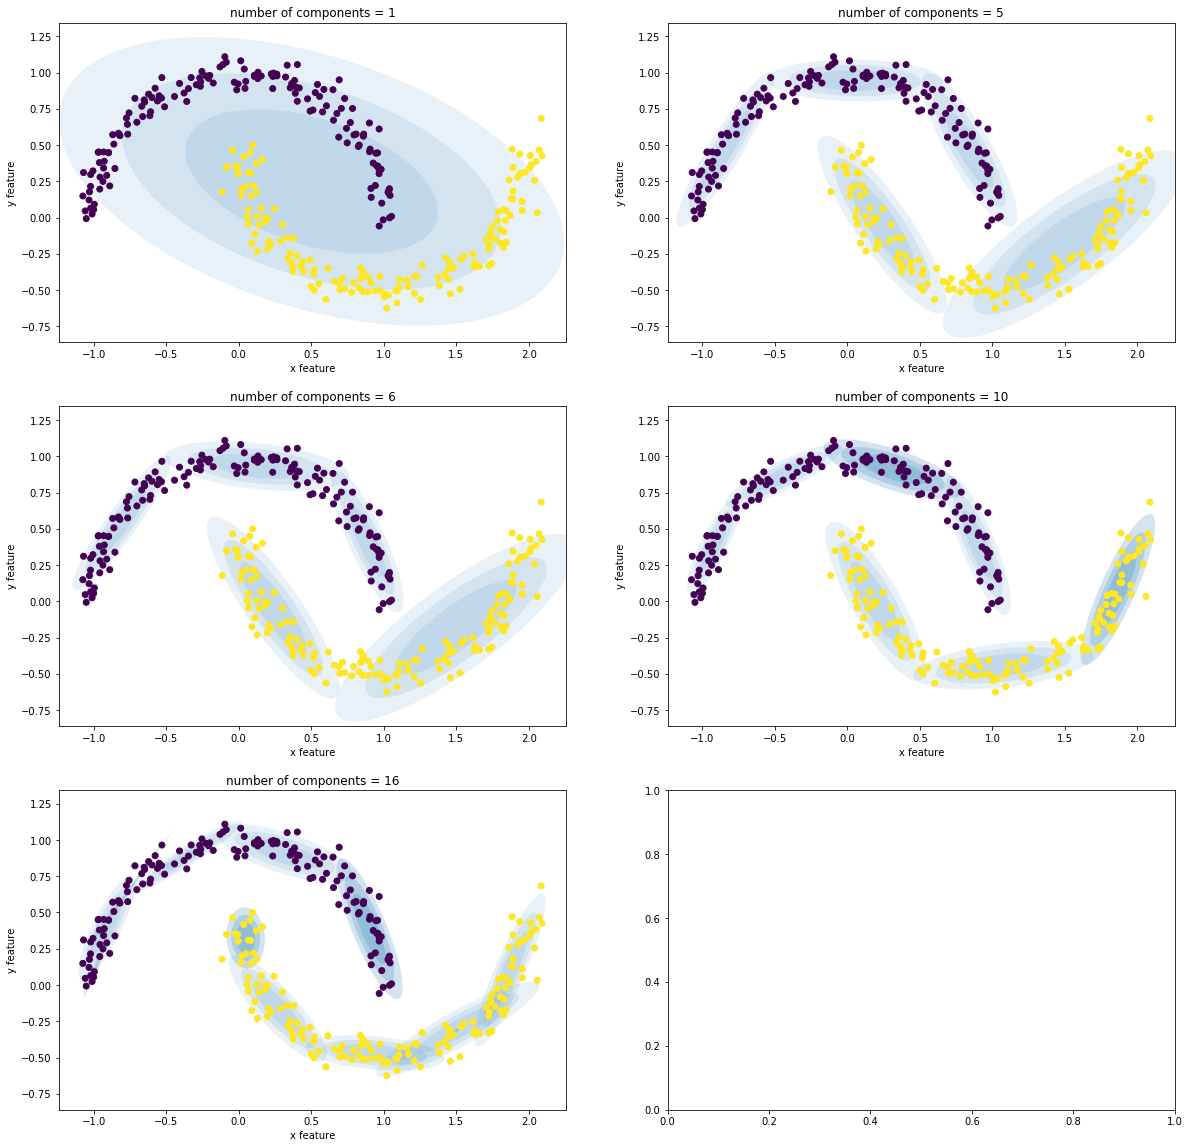

In [20]:
fig, ax = plt.subplots(3,2,figsize=(20,20))
ax = ax.flatten()

i = 0
for j in [1, 5, 6, 10, 16]:
    gmm = GMM(j, 200)
    gmm.init_params(X)
    gmm.fit(X)
    g_params = zip(gmm.mius, gmm.covs)
    ax[i].axis('equal')
    ax[i].scatter(X[:,0], X[:,1], c=y, zorder=2)
    plot_contour(ax[i], g_params)
    ax[i].set_title('number of components = ' + str(j))
    ax[i].set_xlabel('x feature')
    ax[i].set_ylabel('y feature')
    i = i+1

## Plotting AIC and BIC for 16 numbers:

In [11]:
num_components = 16
x = np.arange(1, num_components)
models = []
for i in x:
    gmm = GMM(i, 200)
    gmm.init_params(X)
    gmm.fit(X)
    models.append(gmm)
    
bics = [m.bic(X) for m in models]
aics = [m.aic(X) for m in models]

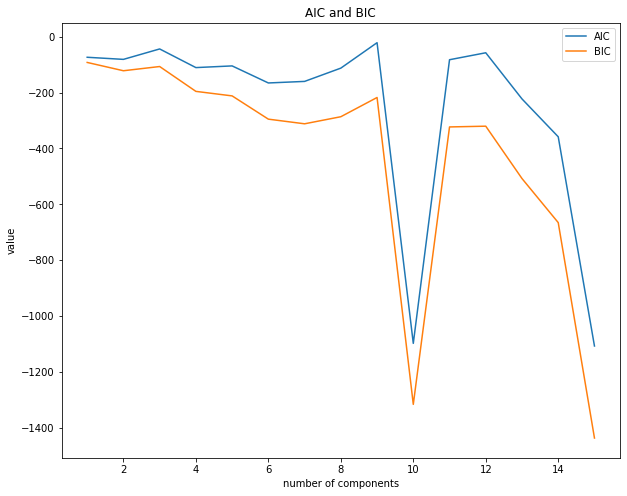

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, bics, label='AIC')
ax.plot(x, aics, label='BIC')
ax.set_title('AIC and BIC')
ax.set_xlabel('number of components')
ax.set_ylabel('value') ##Chelsea
ax.legend();

The smaller the AIC and BIC the better the result:
    As we can see above 10 number of components is optimal